In [398]:
import pandas as pd
import psycopg2

In [399]:
DB_HOST = '89.145.163.87'
DB_PORT = 5432
DB_USERNAME = 'group11'
DB_PASSWORD = 'tsw2020'
DB_NAME = 'tweets'

In [ ]:
COUNTRY = 'netherlands'

In [400]:
def db_to_pandas(query):
    """ Query database to a Pandas DF"""
    conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USERNAME, password=DB_PASSWORD)
    cur = conn.cursor()
    
    df = pd.read_sql_query(query, conn)
    print(df.info)
    
    cur.close()
    conn.close()
    
    return df

In [507]:
sql_query = """
SELECT tweet_id, concepts, tweet_body->>'created_at' as created_at
FROM tweet
WHERE location_id LIKE '{}%'
AND concepts IS NOT NULL;
""".format(COUNTRY)

df_from_db = db_to_pandas(sql_query)

<bound method DataFrame.info of                   tweet_id                                           concepts  \
0      1235874511221858304  [{'percentageOfSecondRank': 0.0, 'offset': 67,...   
1      1234209572933578752  [{'percentageOfSecondRank': 0.0, 'offset': 95,...   
2      1234211571817205760  [{'percentageOfSecondRank': 0.0, 'offset': 53,...   
3      1234213418598576128  [{'percentageOfSecondRank': 0.0, 'offset': 56,...   
4      1234213546298413061  [{'percentageOfSecondRank': 0.0, 'offset': 56,...   
...                    ...                                                ...   
36758  1236703472600395776  [{'percentageOfSecondRank': 0.0, 'offset': 29,...   
36759  1236703669581688832  [{'percentageOfSecondRank': 0.0, 'offset': 29,...   
36760  1236698858882818048  [{'percentageOfSecondRank': 0.0001256787896195...   
36761  1236640975981883392  [{'percentageOfSecondRank': 0.0001676319741651...   
36762  1236725007075676160  [{'percentageOfSecondRank': 0.0345091833483013...

In [508]:
# convert to timestamps to days
df_from_db['date'] = pd.to_datetime(df_from_db['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_from_db['date'] = df_from_db.date.dt.normalize()

df_from_db.info

<bound method DataFrame.info of                   tweet_id                                           concepts  \
0      1235874511221858304  [{'percentageOfSecondRank': 0.0, 'offset': 67,...   
1      1234209572933578752  [{'percentageOfSecondRank': 0.0, 'offset': 95,...   
2      1234211571817205760  [{'percentageOfSecondRank': 0.0, 'offset': 53,...   
3      1234213418598576128  [{'percentageOfSecondRank': 0.0, 'offset': 56,...   
4      1234213546298413061  [{'percentageOfSecondRank': 0.0, 'offset': 56,...   
...                    ...                                                ...   
36758  1236703472600395776  [{'percentageOfSecondRank': 0.0, 'offset': 29,...   
36759  1236703669581688832  [{'percentageOfSecondRank': 0.0, 'offset': 29,...   
36760  1236698858882818048  [{'percentageOfSecondRank': 0.0001256787896195...   
36761  1236640975981883392  [{'percentageOfSecondRank': 0.0001676319741651...   
36762  1236725007075676160  [{'percentageOfSecondRank': 0.0345091833483013...

In [509]:
# expand concepts to have its own series
a = df_from_db.explode('concepts')
concept_df = (a.assign(concepts = a['concepts'].str.get('surfaceForm'))\
              .groupby(['date','concepts'])['concepts'].count().reset_index(name='count'))
print(concept_df)

           date     concepts  count
0    2020-02-25   12 monkeys      1
1    2020-02-25     14 maart      1
2    2020-02-25   18 januari      1
3    2020-02-25     23 april      1
4    2020-02-25  25 februari      3
...         ...          ...    ...
5303 2020-03-09    nieuwsuur      1
5304 2020-03-09     outbreak      1
5305 2020-03-09  quarantaine      2
5306 2020-03-09         rivm      2
5307 2020-03-09       single      1

[5308 rows x 3 columns]


In [510]:
top_concepts = concept_df.groupby(['concepts']).agg({'count':sum}).sort_values(['count'], ascending=False)
top_concepts.info

<bound method DataFrame.info of                    count
concepts                
coronavirus        19228
Nederland           5030
Coronavirus         3729
RIVM                2644
GGD                 1774
...                  ...
Rotterdam Airport      1
Roma                   1
Rode kruis             1
Robert Long            1
Ämter                  1

[2389 rows x 1 columns]>

In [511]:
# find interesting concepts to take into account
for i, c in top_concepts.iterrows():
    print(c)

count    19228
Name: coronavirus, dtype: int64
count    5030
Name: Nederland, dtype: int64
count    3729
Name: Coronavirus, dtype: int64
count    2644
Name: RIVM, dtype: int64
count    1774
Name: GGD, dtype: int64
count    845
Name: Iran, dtype: int64
count    788
Name: China, dtype: int64
count    774
Name: quarantaine, dtype: int64
count    757
Name: koorts, dtype: int64
count    745
Name: rivm, dtype: int64
count    744
Name: Wuhan, dtype: int64
count    674
Name: Amsterdam, dtype: int64
count    573
Name: Noord-Brabant, dtype: int64
count    555
Name: griep, dtype: int64
count    518
Name: Italiaanse, dtype: int64
count    448
Name: EU, dtype: int64
count    444
Name: Florence, dtype: int64
count    430
Name: Italië, dtype: int64
count    386
Name: outbreak, dtype: int64
count    362
Name: Rotterdam, dtype: int64
count    335
Name: Venetië, dtype: int64
count    321
Name: 2 februari, dtype: int64
count    296
Name: D66, dtype: int64
count    262
Name: Tilburg, dtype: int64
count   

Name: Litouwen, dtype: int64
count    9
Name: Belgie, dtype: int64
count    9
Name: IT, dtype: int64
count    9
Name: genetische code, dtype: int64
count    9
Name: Dordrecht, dtype: int64
count    9
Name: olieprijs, dtype: int64
count    9
Name: genomics, dtype: int64
count    9
Name: Leidschendam-Voorburg, dtype: int64
count    9
Name: Buren, dtype: int64
count    9
Name: handhygiëne, dtype: int64
count    9
Name: Nigeria, dtype: int64
count    9
Name: Pandemie, dtype: int64
count    9
Name: Imperial College London, dtype: int64
count    9
Name: biblebelt, dtype: int64
count    9
Name: postbus 51, dtype: int64
count    9
Name: blockchain, dtype: int64
count    9
Name: Afrika, dtype: int64
count    8
Name: Asjkenazische, dtype: int64
count    8
Name: Rob Trip, dtype: int64
count    8
Name: Genève, dtype: int64
count    8
Name: Richard, dtype: int64
count    8
Name: CNN, dtype: int64
count    8
Name: opperrabbijn, dtype: int64
count    8
Name: 26 februari, dtype: int64
count    8
Name:

Name: 25 oktober, dtype: int64
count    4
Name: Jesus, dtype: int64
count    3
Name: angststoornis, dtype: int64
count    3
Name: Eine, dtype: int64
count    3
Name: SEH, dtype: int64
count    3
Name: BP, dtype: int64
count    3
Name: olvg, dtype: int64
count    3
Name: HSBC, dtype: int64
count    3
Name: Elfstedentocht, dtype: int64
count    3
Name: antistof, dtype: int64
count    3
Name: SBS6, dtype: int64
count    3
Name: tenerife, dtype: int64
count    3
Name: Queen, dtype: int64
count    3
Name: 28 februari, dtype: int64
count    3
Name: amoer, dtype: int64
count    3
Name: BuZa, dtype: int64
count    3
Name: oder, dtype: int64
count    3
Name: Göppingen, dtype: int64
count    3
Name: amersfoort, dtype: int64
count    3
Name: hacking, dtype: int64
count    3
Name: luizen, dtype: int64
count    3
Name: GCC, dtype: int64
count    3
Name: hamster, dtype: int64
count    3
Name: grot, dtype: int64
count    3
Name: vakbeurs, dtype: int64
count    3
Name: DNA, dtype: int64
count    3
Nam

Name: King County, dtype: int64
count    2
Name: Staatsloterij, dtype: int64
count    2
Name: noodle, dtype: int64
count    2
Name: nos nieuws, dtype: int64
count    2
Name: Guangdong, dtype: int64
count    2
Name: Grünen, dtype: int64
count    2
Name: ski, dtype: int64
count    2
Name: Groenlinks, dtype: int64
count    2
Name: Groene Hart, dtype: int64
count    2
Name: Sri Lanka, dtype: int64
count    2
Name: nba, dtype: int64
count    2
Name: no doubt, dtype: int64
count    2
Name: Green Day, dtype: int64
count    2
Name: Goldberg, dtype: int64
count    2
Name: neum, dtype: int64
count    2
Name: nerd, dtype: int64
count    2
Name: Glasgow, dtype: int64
count    2
Name: Noord-Ierland, dtype: int64
count    2
Name: Noord-Holland, dtype: int64
count    2
Name: HAVO, dtype: int64
count    2
Name: sinus, dtype: int64
count    2
Name: oldtimer, dtype: int64
count    2
Name: Nicolás Maduro, dtype: int64
count    2
Name: HILVERSUM, dtype: int64
count    2
Name: New England, dtype: int64
cou

Name: overkill, dtype: int64
count    1
Name: overijssel, dtype: int64
count    1
Name: lombardijen, dtype: int64
count    1
Name: groen!, dtype: int64
count    1
Name: vvd, dtype: int64
count    1
Name: vluchtelingencrisis, dtype: int64
count    1
Name: voetballer, dtype: int64
count    1
Name: trave, dtype: int64
count    1
Name: hartspier, dtype: int64
count    1
Name: nod, dtype: int64
count    1
Name: slapeloosheid, dtype: int64
count    1
Name: instinct, dtype: int64
count    1
Name: hellendoorn, dtype: int64
count    1
Name: helmond, dtype: int64
count    1
Name: voetbalwedstrijd, dtype: int64
count    1
Name: nijverdal, dtype: int64
count    1
Name: herpes, dtype: int64
count    1
Name: highschool, dtype: int64
count    1
Name: slayer, dtype: int64
count    1
Name: vlissingen, dtype: int64
count    1
Name: slide, dtype: int64
count    1
Name: neusverkoudheid, dtype: int64
count    1
Name: voetbaltrainer, dtype: int64
count    1
Name: vogelgriep, dtype: int64
count    1
Name: si

Name: Zuidas, dtype: int64
count    1
Name: Zweten, dtype: int64
count    1
Name: all that, dtype: int64
count    1
Name: astrologisch, dtype: int64
count    1
Name: asterix, dtype: int64
count    1
Name: asielzoekerscentra, dtype: int64
count    1
Name: asielrecht, dtype: int64
count    1
Name: arbodienst, dtype: int64
count    1
Name: antibioticum, dtype: int64
count    1
Name: antibiotica, dtype: int64
count    1
Name: aloë, dtype: int64
count    1
Name: alibaba, dtype: int64
count    1
Name: Zwitsers, dtype: int64
count    1
Name: algoritme, dtype: int64
count    1
Name: algiers, dtype: int64
count    1
Name: ale, dtype: int64
count    1
Name: agen, dtype: int64
count    1
Name: acupuncturist, dtype: int64
count    1
Name: accept, dtype: int64
count    1
Name: aalsmeer, dtype: int64
count    1
Name: Zürich, dtype: int64
count    1
Name: Wake, dtype: int64
count    1
Name: Waalwijk, dtype: int64
count    1
Name: WC-papier, dtype: int64
count    1
Name: Toyota, dtype: int64
count    

In [435]:
stop = ('coronavirus', 'Coronavirus', 'Corona', 'CoronaVirus', 'do', 'amp', 'Deutschland', 'via', 'tun', 'primer', 'un', 'del')
relevant_top = concept_df[~concept_df.concepts.isin(stop)]
relevant_top.groupby(['concepts']).agg({'count':sum}).sort_values(['count'], ascending=False)

,count
concepts,
china,12476
China,6932
Berlin,4188
Italien,2796
Virus,2072
...,...
Occidental,1
Offenbarungseid,1
Offenburg,1


In [504]:
def merge_topics(df, topic):
    cdf = df[df['concepts'].isin(topic['topics'])]
    cdf.loc[:,'concepts'] = topic['name']
    return cdf.groupby(['date']).agg({'count':sum}).reset_index()

In [518]:
"""GERMANY
protect = {'name': 'protection','topics': ['Desinfektionsmittel', 'Mundschutz', 'Klopapier']}
countries = {'name': 'other countries', 'topics': ['Italien', 'Iran', 'Südkorea', 'China', 'US', 'USA']}
sources = {'name': 'public institutions', 'topics': ['Robert-Koch Institut', 'RKI', 'Jens Spahr', 'Bundesregierung', 'Merkel', 'Angela Merkel']}
"""
"""NETHERLANDS"""
protect = {'name': 'protection','topics': ['quarantaine']}
countries = {'name': 'other countries', 'topics': ['Iran', 'China', 'Italiaanse', 'Italië', 'Korea', 'Japan', 'Duitsland']}
sources = {'name': 'public institutions', 'topics': ['RVIM', 'GGD', 'rivm', 'Mark Rutte']}


df1 = merge_topics(concept_df, protect)
df2 = merge_topics(concept_df, countries)
df3 = merge_topics(concept_df, sources)
df1['concepts'] = 'protection'
df2['concepts'] = 'countries'
df3['concepts'] = 'public institutions'
interesting_df = pd.concat([df1, df2, df3])
interesting_df.head()

,date,count,concepts
0,2020-02-25,27,protection
1,2020-02-26,17,protection
2,2020-02-27,22,protection
3,2020-02-28,29,protection
4,2020-02-29,7,protection


In [513]:
sql_query = """
SELECT tweet_body->>'created_at' as created_at
FROM tweet
WHERE location_id LIKE '{}%';
""".format(COUNTRY)

all_tweets = db_to_pandas(sql_query)
all_tweets['date'] = pd.to_datetime(all_tweets['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
all_tweets['date'] = all_tweets.date.dt.normalize()

total_tweets = all_tweets['date'].value_counts()
total_tweets = total_tweets.to_frame().reset_index().rename(columns={'index': 'date', 'date': 'count'})
total_tweets.info
#total_tweets = total_tweets.reset_index()


total_tweets

<bound method DataFrame.info of                            created_at
0      Fri Mar 06 10:26:59 +0000 2020
1      Sun Mar 01 20:47:24 +0000 2020
2      Sun Mar 01 20:47:43 +0000 2020
3      Sun Mar 01 20:21:10 +0000 2020
4      Sun Mar 01 20:45:06 +0000 2020
...                               ...
48975  Sun Mar 08 17:20:59 +0000 2020
48976  Sun Mar 08 17:21:46 +0000 2020
48977  Sun Mar 08 17:02:39 +0000 2020
48978  Sun Mar 08 13:12:39 +0000 2020
48979  Sun Mar 08 18:46:33 +0000 2020

[48980 rows x 1 columns]>


,date,count
0,2020-02-28,6245
1,2020-03-08,4762
2,2020-02-27,4726
3,2020-03-05,4279
4,2020-03-06,4231
5,2020-03-01,4028
6,2020-03-02,3756
7,2020-03-07,3663
8,2020-03-03,3292
9,2020-02-29,2963


In [ ]:
!pip install seaborn

         date  count             concepts
0  2020-02-25     27           protection
1  2020-02-26     17           protection
2  2020-02-27     22           protection
3  2020-02-28     29           protection
4  2020-02-29      7           protection
5  2020-03-01     31           protection
6  2020-03-02     25           protection
7  2020-03-03      6           protection
8  2020-03-04     26           protection
9  2020-03-05     58           protection
10 2020-03-06     11           protection
11 2020-03-07     36           protection
12 2020-03-08    477           protection
13 2020-03-09      2           protection
0  2020-02-25    209            countries
1  2020-02-26    129            countries
2  2020-02-27    195            countries
3  2020-02-28    211            countries
4  2020-02-29    358            countries
5  2020-03-01    275            countries
6  2020-03-02    214            countries
7  2020-03-03    158            countries
8  2020-03-04    180            co

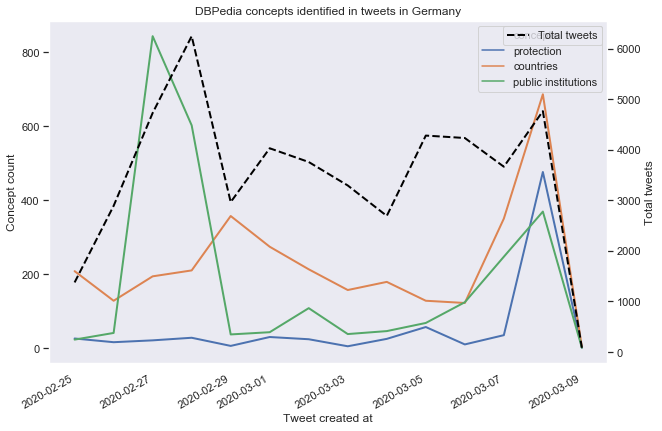

In [522]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

sns.set(style="dark")
plt.title("DBPedia concepts identified in tweets in {}".format(COUNTRY))

#sns.set_context("talk")

# set size of figure
rcParams['figure.figsize'] = 10,7

# first axis
plot_df = interesting_df

print(plot_df)
ax1 = sns.lineplot(data=plot_df, x='date', y='count', hue='concepts', linewidth=2)
ax1.set(xlabel='Tweet created at', ylabel='Concept count')

# second axis
ax2 = plt.twinx()
sns.lineplot(data=total_tweets, x='date', y='count', color="black", ax=ax2, linewidth=2)
ax2.grid(False)
ax2.set(ylabel='Total tweets')
ax2.lines[0].set_linestyle("--")

plt.legend(labels=['Total tweets', 'x'])

plt.gcf().autofmt_xdate()